In [1]:
import os
import sys
import numpy as np
import traci
from keras import models, layers, optimizers
from collections import deque

C:\Users\Eugenio\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
### halting 

In [3]:
def TL_state(detectors_ID):	
    state_list = []		
    for detector in detectors_ID:
        speed = traci.lanearea.getLastStepMeanSpeed(detector)
        # Returns the mean speed of vehicles that were 
        # on the named induction loop within the last simulation step [m/s]
        state_list.append(speed)

        n_veh = traci.lanearea.getLastStepVehicleNumber(detector)
        # Returns the number of vehicles that were 
        # on the named induction loop within the last simulation step [m/s]
        state_list.append(n_veh)

    state_list.append(traci.trafficlight.getPhase(traci.trafficlight.getIDList()[0]))
    state = np.reshape(state_list, [1, 25])
    return state

In [4]:
def TL_reward(detectors_ID):
    halting = []
    for detector in detectors_ID:
        halting.append(-traci.lanearea.getLastStepHaltingNumber(detector))
    return sum(halting)

In [5]:
class AgentClass(object):
    """docstring for agent"""
    def __init__(self,exploration):
        self.actions_list = [0,1,2,3] # 4 actions: straight N-S, left turn N-W/S-E, straight E-W, left turn W-N/E-S
        self.training_memory = deque(maxlen=10000)
        self.epsilon = exploration
        self.eps_decay = 0.998
        self.min_eps = 0.01
        self.model = self.createNN()
        self.target_model = self.createNN()
        self.gamma = 0.99

    def createNN(self):
        model = models.Sequential()
        model.add(layers.Dense(16,activation='relu',input_dim=25))
        model.add(layers.Dense(16,activation='relu',))
        model.add(layers.Dense(4,activation='linear')) 
        opt = optimizers.Adam(lr=0.001)
        model.compile(optimizer = opt, loss='mse')
        return model

    def update_target_network(self):
        self.target_model.set_weights(self.model.get_weights()) 

    def select_action(self,state):
        action = None
        if self.epsilon > np.random.rand():
            action = np.random.choice(self.actions_list) 
        else:
            action = np.argmax(self.model.predict(state)[0])
        return action

    def memory(self,state,reward,next_s,a,done):
        self.training_memory.append((state,reward,next_s,a,done))


    def fit_NN(self):
        data = np.array(self.training_memory)  
        batch = data[np.random.randint(data.shape[0], size=32), :]

        Q_target = np.zeros((32, 4))
        state_vector = np.zeros((32, 25))
        i=0
        for state,reward,next_s,a,done in batch:
            if done:
                Q1 = reward
            else:
                Q1 = reward + self.gamma*np.max(self.target_model.predict(next_s)[0])
                
            Q = self.model.predict(state)
            state_vector[i] = state
            Q_target[i] = Q
            Q_target[i][a] = Q1
            i += 1
        self.model.fit(state_vector,Q_target, epochs=1, batch_size=batch.shape[0], verbose=0)    

    def decay(self,t):
        self.epsilon = self.min_eps + (1 - self.min_eps)*np.exp(-0.000015*t)

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

In [6]:
sumoBinary = "C:/Program Files (x86)/DLR/Sumo/bin/sumo" # SUMO path
sumoCmd = [sumoBinary, "-c", "SUMO_files/cross.sumocfg"]

traci.start(sumoCmd) # starts the SUMO simulation defined in sumoCmd

(17, 'SUMO 0.32.0')

In [7]:
traci.close()

In [6]:
sumoBinary = "C:/Program Files (x86)/DLR/Sumo/bin/sumo" # SUMO path
sumoCmd = [sumoBinary, "-c", "SUMO_files_3c/crossD.sumocfg"]

traci.start(sumoCmd) # starts the SUMO simulation defined in sumoCmd

TL_id = traci.trafficlight.getIDList() # list of traffic lights (just one n this case)
total_step = 1200                      # total step of eachs simulation
detectors_ID = traci.lanearea.getIDList()
total_episodes = 1201
update_time = 5
transition_time = 5                    # time for yellow phase
agent = AgentClass(1)
traci.close()
t = 0
epsilon_list = []
total_reward_per_episode = []
actions = [0,3,6,9]            # number of phase of the traffic light 



for episode in range(total_episodes):
    traci.start(sumoCmd)
    traci.trafficlight.setPhase(TL_id[0], 0)
    state = TL_state(detectors_ID) 
    total_reward = 0
    step = 0
    done = False
    prev_action = 0

    while step <= total_step:
        action = agent.select_action(state)  
        phase = actions[action]

        if action != prev_action:     # if the agent switches phase, there is the yellow light first
            curr_phase = traci.trafficlight.getPhase(TL_id[0])
            traci.trafficlight.setPhase(TL_id[0], curr_phase + 1)
            for i in range(transition_time):
                traci.simulationStep()
            traci.trafficlight.setPhase(TL_id[0], phase)
                
        for j in range(update_time):
            traci.simulationStep()
            step+=1
            
        reward = TL_reward(detectors_ID)
        next_s = TL_state(detectors_ID)
        if step == total_step:
            done = True
        agent.memory(state,reward,next_s,action,done) 
        total_reward += reward
        state = next_s
        prev_action = action
        if episode > 5:
            agent.fit_NN()
            agent.decay(t)
            t += 1

    
    total_reward_per_episode.append(total_reward)
    epsilon_list.append(agent.epsilon)
    agent.update_target_network()
    traci.close()
    print('Episode: {}'.format(episode),
      'Total reward: {}'.format(total_reward),
      'Explore P: {:.4f}'.format(agent.epsilon))
    if episode % 100 == 0:
        agent.save('model_weights_haltingD5.h5')

Episode: 0 Total reward: -19186 Explore P: 1.0000
Episode: 1 Total reward: -18980 Explore P: 1.0000
Episode: 2 Total reward: -16677 Explore P: 1.0000
Episode: 3 Total reward: -20508 Explore P: 1.0000
Episode: 4 Total reward: -18963 Explore P: 1.0000
Episode: 5 Total reward: -20990 Explore P: 1.0000
Episode: 6 Total reward: -18015 Explore P: 0.9964
Episode: 7 Total reward: -19193 Explore P: 0.9929
Episode: 8 Total reward: -19198 Explore P: 0.9893
Episode: 9 Total reward: -17586 Explore P: 0.9858
Episode: 10 Total reward: -18100 Explore P: 0.9823
Episode: 11 Total reward: -15291 Explore P: 0.9788
Episode: 12 Total reward: -18381 Explore P: 0.9753
Episode: 13 Total reward: -16455 Explore P: 0.9718
Episode: 14 Total reward: -16107 Explore P: 0.9683
Episode: 15 Total reward: -19310 Explore P: 0.9649
Episode: 16 Total reward: -18289 Explore P: 0.9614
Episode: 17 Total reward: -15405 Explore P: 0.9580
Episode: 18 Total reward: -17875 Explore P: 0.9546
Episode: 19 Total reward: -17475 Explore 

Episode: 160 Total reward: -11986 Explore P: 0.5753
Episode: 161 Total reward: -13023 Explore P: 0.5733
Episode: 162 Total reward: -12168 Explore P: 0.5712
Episode: 163 Total reward: -12812 Explore P: 0.5692
Episode: 164 Total reward: -12484 Explore P: 0.5672
Episode: 165 Total reward: -11300 Explore P: 0.5652
Episode: 166 Total reward: -11668 Explore P: 0.5632
Episode: 167 Total reward: -10486 Explore P: 0.5612
Episode: 168 Total reward: -8993 Explore P: 0.5592
Episode: 169 Total reward: -11468 Explore P: 0.5572
Episode: 170 Total reward: -12106 Explore P: 0.5553
Episode: 171 Total reward: -11520 Explore P: 0.5533
Episode: 172 Total reward: -10912 Explore P: 0.5513
Episode: 173 Total reward: -10808 Explore P: 0.5494
Episode: 174 Total reward: -10916 Explore P: 0.5474
Episode: 175 Total reward: -11537 Explore P: 0.5455
Episode: 176 Total reward: -10933 Explore P: 0.5436
Episode: 177 Total reward: -11871 Explore P: 0.5416
Episode: 178 Total reward: -12129 Explore P: 0.5397
Episode: 179 

Episode: 319 Total reward: -6082 Explore P: 0.3282
Episode: 320 Total reward: -7903 Explore P: 0.3270
Episode: 321 Total reward: -9576 Explore P: 0.3259
Episode: 322 Total reward: -7359 Explore P: 0.3247
Episode: 323 Total reward: -7213 Explore P: 0.3236
Episode: 324 Total reward: -8471 Explore P: 0.3225
Episode: 325 Total reward: -6450 Explore P: 0.3214
Episode: 326 Total reward: -7707 Explore P: 0.3202
Episode: 327 Total reward: -7813 Explore P: 0.3191
Episode: 328 Total reward: -5272 Explore P: 0.3180
Episode: 329 Total reward: -6151 Explore P: 0.3169
Episode: 330 Total reward: -4336 Explore P: 0.3158
Episode: 331 Total reward: -6322 Explore P: 0.3147
Episode: 332 Total reward: -7460 Explore P: 0.3136
Episode: 333 Total reward: -9683 Explore P: 0.3125
Episode: 334 Total reward: -6091 Explore P: 0.3114
Episode: 335 Total reward: -6641 Explore P: 0.3103
Episode: 336 Total reward: -6593 Explore P: 0.3092
Episode: 337 Total reward: -7023 Explore P: 0.3081
Episode: 338 Total reward: -617

Episode: 480 Total reward: -4798 Explore P: 0.1878
Episode: 481 Total reward: -5088 Explore P: 0.1871
Episode: 482 Total reward: -5339 Explore P: 0.1865
Episode: 483 Total reward: -5374 Explore P: 0.1859
Episode: 484 Total reward: -5719 Explore P: 0.1852
Episode: 485 Total reward: -6842 Explore P: 0.1846
Episode: 486 Total reward: -5360 Explore P: 0.1840
Episode: 487 Total reward: -5725 Explore P: 0.1833
Episode: 488 Total reward: -5001 Explore P: 0.1827
Episode: 489 Total reward: -5187 Explore P: 0.1821
Episode: 490 Total reward: -5409 Explore P: 0.1815
Episode: 491 Total reward: -5705 Explore P: 0.1809
Episode: 492 Total reward: -5247 Explore P: 0.1802
Episode: 493 Total reward: -4154 Explore P: 0.1796
Episode: 494 Total reward: -4531 Explore P: 0.1790
Episode: 495 Total reward: -5294 Explore P: 0.1784
Episode: 496 Total reward: -5405 Explore P: 0.1778
Episode: 497 Total reward: -6021 Explore P: 0.1772
Episode: 498 Total reward: -5102 Explore P: 0.1766
Episode: 499 Total reward: -563

Episode: 641 Total reward: -22139 Explore P: 0.1093
Episode: 642 Total reward: -18698 Explore P: 0.1090
Episode: 643 Total reward: -21940 Explore P: 0.1086
Episode: 644 Total reward: -17982 Explore P: 0.1083
Episode: 645 Total reward: -19508 Explore P: 0.1079
Episode: 646 Total reward: -19503 Explore P: 0.1076
Episode: 647 Total reward: -20045 Explore P: 0.1072
Episode: 648 Total reward: -21876 Explore P: 0.1069
Episode: 649 Total reward: -19417 Explore P: 0.1065
Episode: 650 Total reward: -20000 Explore P: 0.1062
Episode: 651 Total reward: -22664 Explore P: 0.1058
Episode: 652 Total reward: -21557 Explore P: 0.1055
Episode: 653 Total reward: -19101 Explore P: 0.1051
Episode: 654 Total reward: -19425 Explore P: 0.1048
Episode: 655 Total reward: -19030 Explore P: 0.1044
Episode: 656 Total reward: -18899 Explore P: 0.1041
Episode: 657 Total reward: -21367 Explore P: 0.1038
Episode: 658 Total reward: -20850 Explore P: 0.1034
Episode: 659 Total reward: -22704 Explore P: 0.1031
Episode: 660

Episode: 799 Total reward: -21608 Explore P: 0.0661
Episode: 800 Total reward: -18693 Explore P: 0.0659
Episode: 801 Total reward: -22439 Explore P: 0.0657
Episode: 802 Total reward: -22729 Explore P: 0.0655
Episode: 803 Total reward: -21480 Explore P: 0.0653
Episode: 804 Total reward: -18873 Explore P: 0.0651
Episode: 805 Total reward: -20224 Explore P: 0.0649
Episode: 806 Total reward: -21303 Explore P: 0.0647
Episode: 807 Total reward: -19344 Explore P: 0.0645
Episode: 808 Total reward: -22449 Explore P: 0.0643
Episode: 809 Total reward: -19635 Explore P: 0.0641
Episode: 810 Total reward: -20761 Explore P: 0.0639
Episode: 811 Total reward: -20452 Explore P: 0.0637
Episode: 812 Total reward: -22690 Explore P: 0.0635
Episode: 813 Total reward: -21044 Explore P: 0.0633
Episode: 814 Total reward: -22570 Explore P: 0.0632
Episode: 815 Total reward: -21537 Explore P: 0.0630
Episode: 816 Total reward: -23480 Explore P: 0.0628
Episode: 817 Total reward: -21672 Explore P: 0.0626
Episode: 818

KeyboardInterrupt: 

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

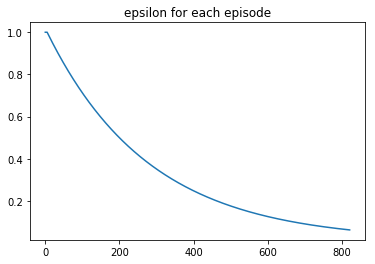

In [8]:
plt.plot(epsilon_list)
plt.title('epsilon for each episode')
plt.show()

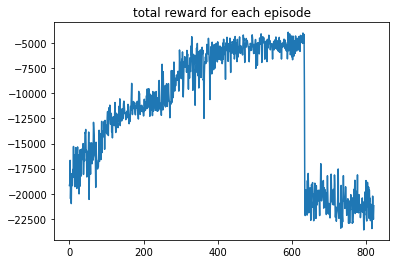

In [9]:
plt.plot(total_reward_per_episode)
plt.title('total reward for each episode')
plt.show()